In [1]:
import heapq
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tqdm import tqdm
from scipy.stats import norm
from itertools import permutations
from collections import defaultdict, deque

In [2]:
class Group:
    def __init__(self, first, second) -> None:
        self.first = first
        self.second = second
    def __repr__(self) -> str:
        return f"<{self.first}, {self.second}>"
    def __eq__(self, other) -> bool:
        return (self.first == other.first and self.second == other.second
                or self.first == other.second and self.second == other.first)
    def __lt__(self, other) -> bool:
        if self.first < other.first:
            return True
        elif self.first == other.first:
            return self.second < other.second
        return False
    def __gt__(self, other) -> bool:
        if self.first > other.first:
            return True
        elif self.first == other.first:
            return self.second > other.second
        return False
    def __hash__(self) -> int:
        if self.first < self.second:
            return hash((self.second, self.first))
        return hash((self.first, self.second))

def mat2list(adj_mat):
    size = len(adj_mat)
    adj_list = defaultdict(list)
    for (_, col), row in adj_mat.iterrows():
        adj_list[col.first].append((col.second, [(k, v) for k, v in zip(row.index, row)]))
        adj_list[col.second].append((col.first, [(k, v) for k, v in zip(row.index, row)]))
    return adj_list

def combine(team, tp):
    return (team, Group(*tp))

class Simulator:
    def __init__(self, adj_mat):
        self.adj_list = mat2list(adj_mat)

class SimulatorA(Simulator):
    def __init__(self, adj_mat):
        super(SimulatorA, self).__init__(adj_mat)
        self.b_name2tok =  {b: i for i, b in enumerate(adj_mat.columns)}
    def tokenize(self, b_seq):
        return [self.b_name2tok[combine('B', b)] for b in b_seq]

class SimulatorB(Simulator):
    def __init__(self, adj_mat):
        super(SimulatorB, self).__init__(adj_mat)
        self.a_name2tok = {a: i for i, a in enumerate(adj_mat.columns)}
    def tokenize(self, a_seq):
        return [self.a_name2tok[combine('A', a)] for a in a_seq]

def get_group(seq1, seq2):
    set_list = []
    for first, second in zip(seq1, seq2):
        if first != second:
            if len(first) != 2:
                first = first[1:]
            if len(second) != 2:
                second = second[1:]
            temp = Group(int(first[-1]), int(second[-1]))
            if not (first[0] != 'A' or first[0] != 'B'):
                raise ValueError(f'{first[0]} (len {len(first)}) is not a valid group')
            set_list.append((first[0], temp))
    return set_list

In [3]:
df = pd.read_csv(r'../table_2.csv', encoding='utf-8', header=None)
df['A'] = get_group(df[2], df[3])
df['B'] = get_group(df[4], df[5])
df['Score_A'] = df[6].apply(lambda x: int(x.split(':')[0]))
df['Score_B'] = df[6].apply(lambda x: int(x.split(':')[1]))
df = df[['A', 'B', 'Score_A', 'Score_B']]
df['Difference'] = df['Score_A'] - df['Score_B']
df['Winner'] = df['Difference'].apply(lambda x: 'A' if x > 0 else 'B')
df.to_csv(r'../table_2_pre.csv', index=False)
df

,A,B,Score_A,Score_B,Difference,Winner
0,"(A, <1, 2>)","(B, <1, 2>)",23,21,2,A
1,"(A, <1, 2>)","(B, <1, 2>)",21,18,3,A
2,"(A, <1, 2>)","(B, <1, 2>)",21,19,2,A
3,"(A, <2, 3>)","(B, <2, 3>)",21,15,6,A
4,"(A, <2, 3>)","(B, <2, 3>)",21,12,9,A
5,"(A, <1, 3>)","(B, <1, 2>)",20,22,-2,B
6,"(A, <1, 3>)","(B, <1, 2>)",21,19,2,A
7,"(A, <1, 3>)","(B, <1, 2>)",22,20,2,A
8,"(A, <2, 4>)","(B, <2, 4>)",21,15,6,A
9,"(A, <2, 4>)","(B, <2, 4>)",13,21,-8,B


In [4]:
index, temp_diff_list, temp_tag_list = -1, list(), list()
game_list, score_list, diff_list, tag_list, game_history_score = list(), list(), list(), list(), tuple()
for line in df.iterrows():
    line = line[-1].copy()
    tp = (line['A'], line['B'])
    if tp not in game_list and len(game_list) > 0:
        diff_list.append(temp_diff_list)
        tag_list.append(temp_tag_list)
    if tp not in game_list:
        game_list.append(tp)
        index += 1
        game_history_score = (0, 0)
        temp_diff_list = []
        temp_tag_list = []
    if line['Difference'] > 0:
        game_history_score = (game_history_score[0] + 1, game_history_score[1])
    else:
        game_history_score = (game_history_score[0], game_history_score[1] + 1)
    temp_diff_list.append(line['Difference'])
    if line['Score_A'] >= 20 and line['Score_B'] >= 20:
        temp_tag_list.append(1)
    else:
        temp_tag_list.append(0)
    if len(score_list) == index:
        score_list.append(game_history_score)
    else:
        score_list[index] = game_history_score
diff_list.append(temp_diff_list)
tag_list.append(temp_tag_list)

df_games = pd.DataFrame()
df_games['games'] = game_list
df_games['score'] = score_list
df_games['A'] = df_games['games'].apply(lambda x: x[0])
df_games['B'] = df_games['games'].apply(lambda x: x[1])
df_games['A_Score'] = df_games['score'].apply(lambda x: x[0])
df_games['B_Score'] = df_games['score'].apply(lambda x: x[1])
df_games['Diff'] = diff_list
df_games['Tag'] = tag_list
df_games.drop(['games', 'score'], axis=1, inplace=True)
df_games.to_csv(r'../games.csv', index=False)
df_games

,A,B,A_Score,B_Score,Diff,Tag
0,"(A, <1, 2>)","(B, <1, 2>)",3,0,"[2, 3, 2]","[1, 0, 0]"
1,"(A, <2, 3>)","(B, <2, 3>)",2,0,"[6, 9]","[0, 0]"
2,"(A, <1, 3>)","(B, <1, 2>)",2,1,"[-2, 2, 2]","[1, 0, 1]"
3,"(A, <2, 4>)","(B, <2, 4>)",1,1,"[6, -8]","[0, 0]"
4,"(A, <1, 4>)","(B, <2, 4>)",2,1,"[-3, 4, 2]","[0, 0, 0]"
5,"(A, <2, 5>)","(B, <3, 5>)",2,0,"[9, 5]","[0, 0]"
6,"(A, <1, 5>)","(B, <1, 5>)",2,1,"[-3, 7, 5]","[0, 0, 0]"
7,"(A, <3, 4>)","(B, <4, 5>)",1,0,[7],[0]
8,"(A, <4, 5>)","(B, <3, 5>)",1,1,"[10, -7]","[0, 0]"
9,"(A, <3, 4>)","(B, <3, 4>)",1,1,"[-2, 2]","[0, 1]"


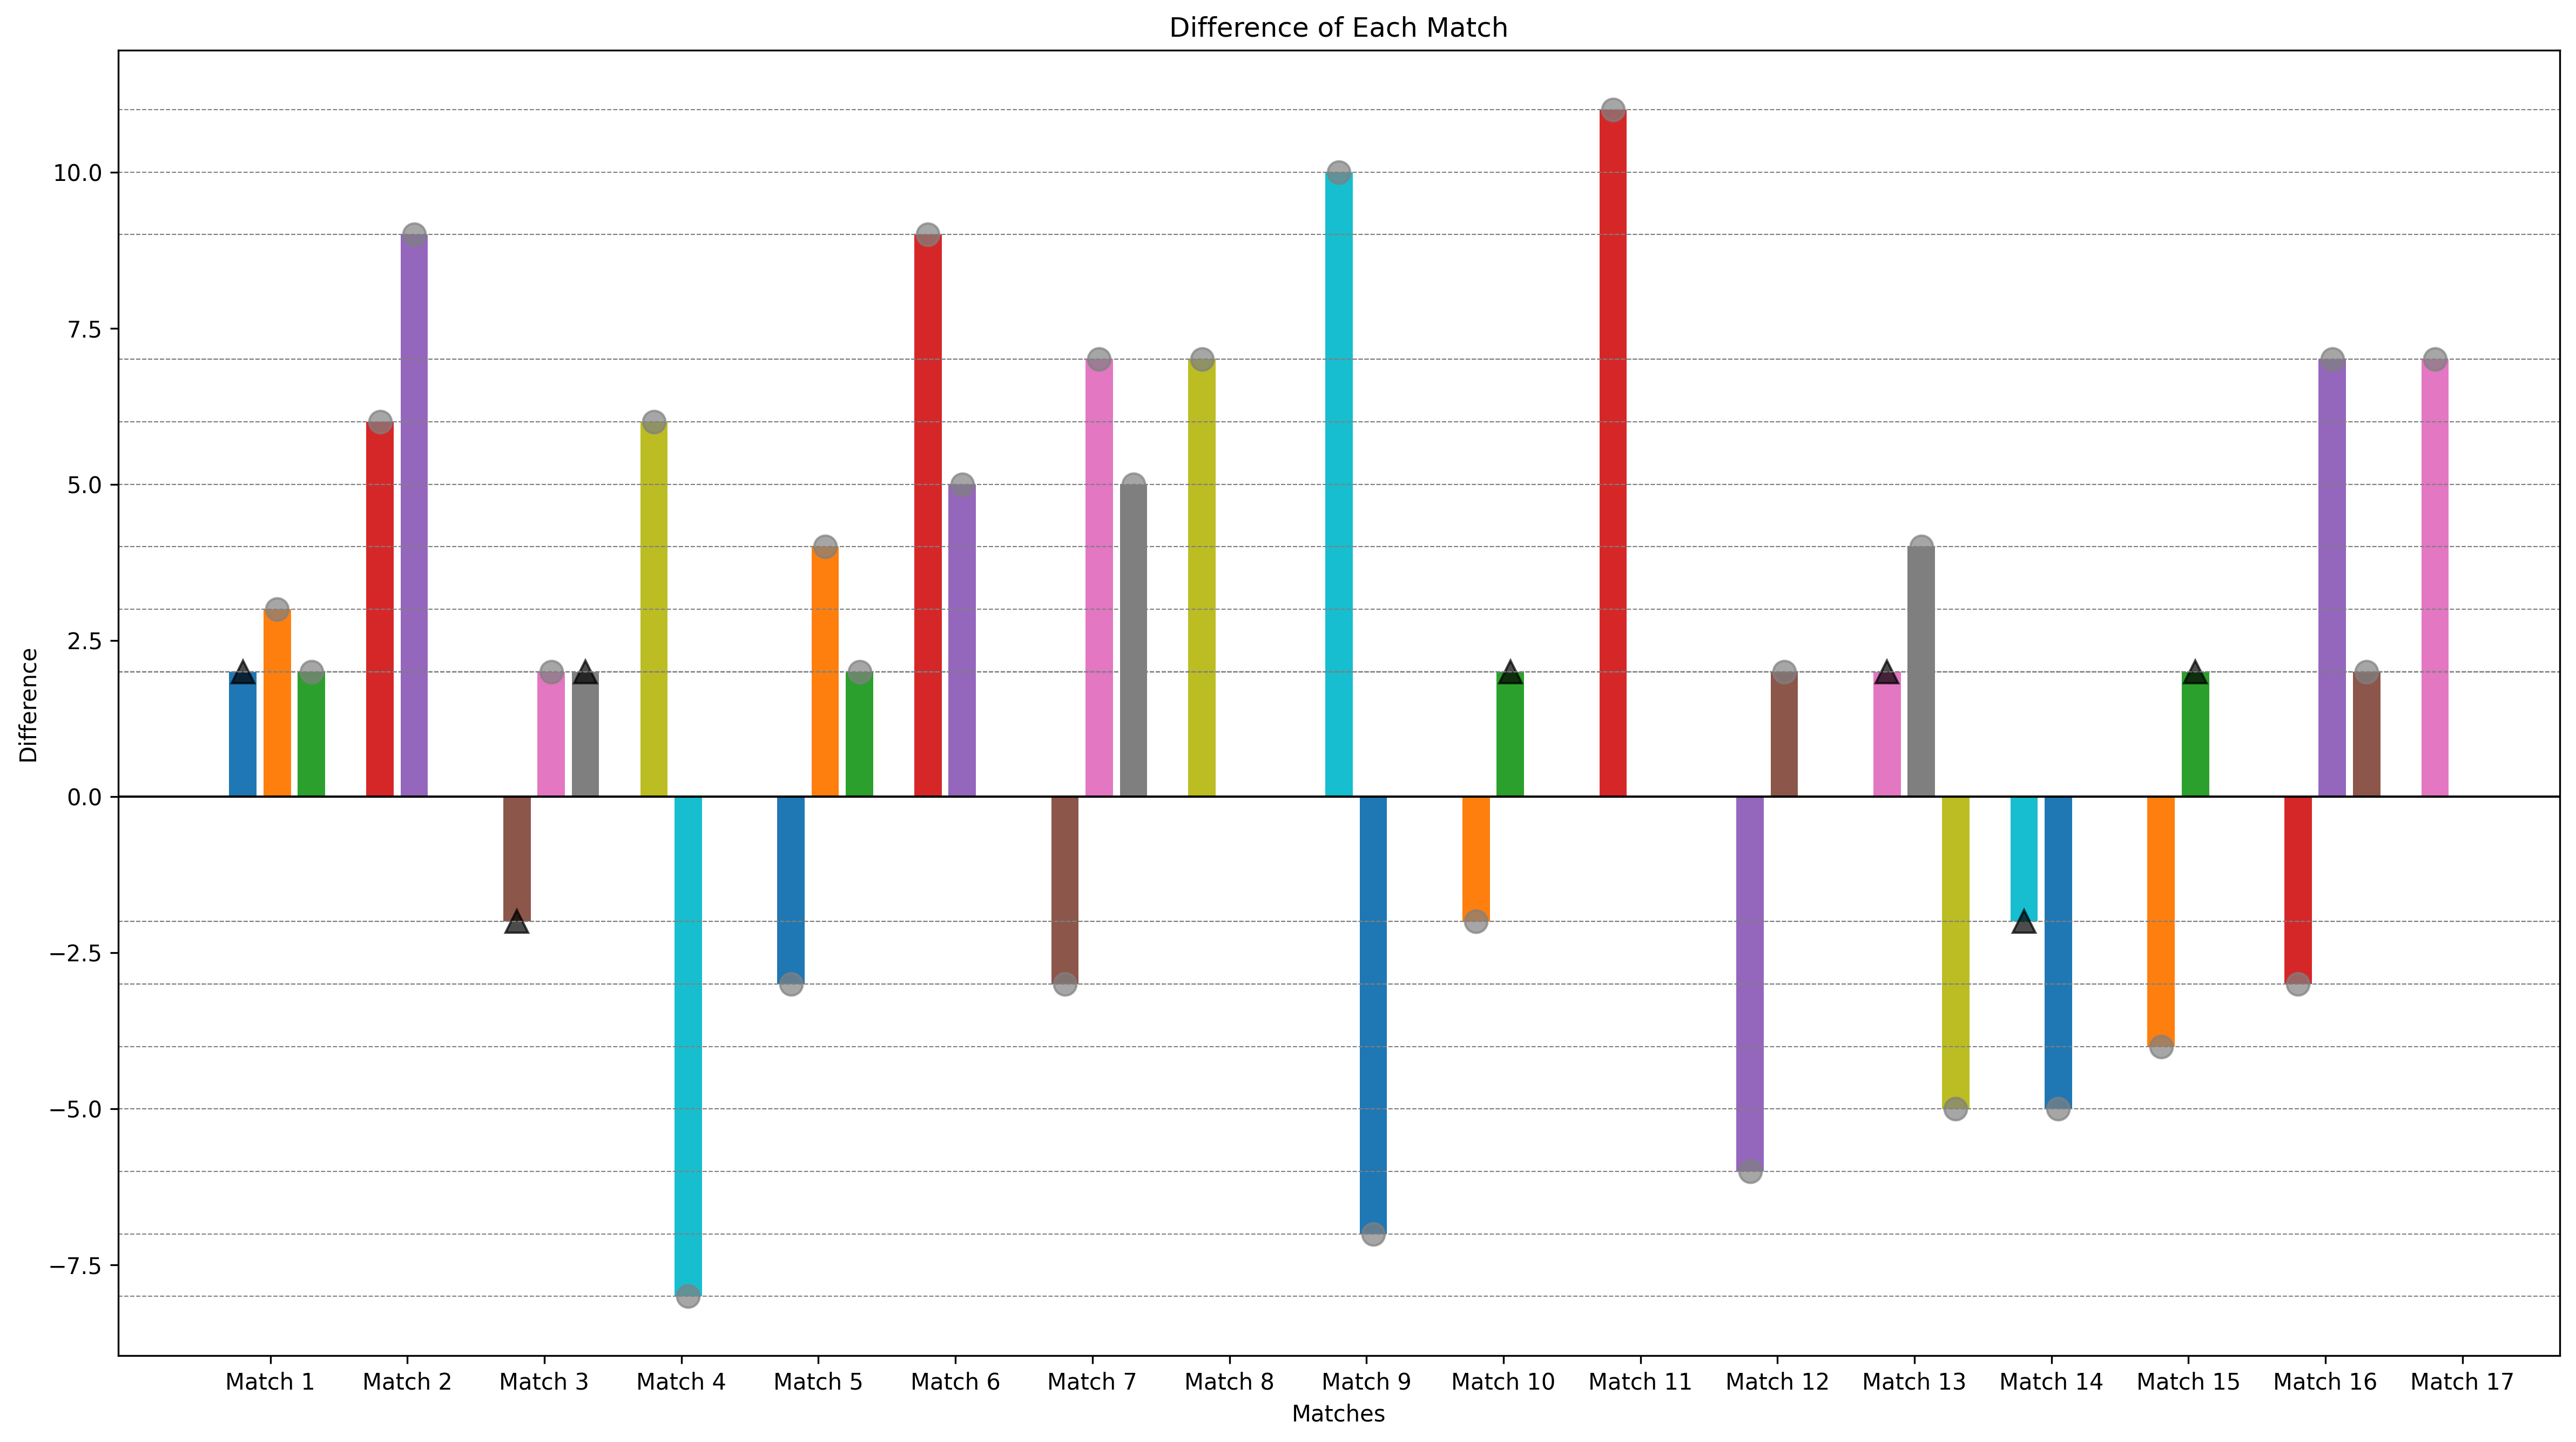

In [5]:
plt.figure(figsize=(16, 9), dpi=300)
ax = plt.gca()

bar_width = 0.2
bar_spacing = 0.05
for i, (diff_list, tag_list) in enumerate(zip(df_games['Diff'], df_games['Tag'])):
    for j, (diff, tag) in enumerate(zip(diff_list, tag_list)):
        x_position = i + j * (bar_width + bar_spacing) - 0.2
        if tag == 1:
            ax.bar(x_position, diff, width=bar_width, label=f'Match {i}', align='center')
        else:
            ax.bar(x_position, diff, width=bar_width, label=f'Match {i}', align='center')
        ax.axhline(y=diff, color='gray', linestyle='--', linewidth=0.5)
        ax.plot(x_position, diff, marker='^' if tag == 1 else 'o', markersize=10, color='black' if tag == 1 else 'grey', alpha=0.7)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)

ax.set_xticks(ticks=range(len(df_games)))
ax.set_xticklabels([f'Match {i + 1}' for i in range(len(df_games))])
ax.set_xlabel('Matches')
ax.set_ylabel('Difference')
ax.set_title('Difference of Each Match')

plt.tight_layout()
plt.show()

In [6]:
G = nx.MultiDiGraph()

plt.figure(figsize=(10, 10), dpi=300)

for _, row in df_games.iterrows():
    for diff, tag in zip(row['Diff'], row['Tag']):
        diff = diff + tag if diff < 0 else diff - tag
        winner = row['A'] if diff > 0 else row['B']
        loser = row['B'] if diff > 0 else row['A']
        G.add_edge(winner, loser, weight=diff)

A_team = {elem for elem in G.nodes() if elem[0] == 'A'}
B_team = set(G) - A_team

<Figure size 3000x3000 with 0 Axes>

In [7]:
a_team, b_team = set(), set()
for i in range(6):
    for j in range(i + 1, 6):
        a_team.add(('A', Group(i + 1, j + 1)))
        b_team.add(('B', Group(i + 1, j + 1)))
print(a_team, b_team, sep='\n')
possible_pairs = []
for a in a_team:
    for b in b_team:
        possible_pairs.append((a,b))
len(a_team), len(b_team), len(possible_pairs)

{('A', <2, 4>), ('A', <4, 5>), ('A', <4, 6>), ('A', <2, 5>), ('A', <1, 2>), ('A', <1, 4>), ('A', <2, 3>), ('A', <1, 6>), ('A', <3, 6>), ('A', <5, 6>), ('A', <1, 5>), ('A', <3, 4>), ('A', <3, 5>), ('A', <2, 6>), ('A', <1, 3>)}
{('B', <4, 5>), ('B', <1, 4>), ('B', <1, 6>), ('B', <4, 6>), ('B', <3, 6>), ('B', <2, 3>), ('B', <1, 5>), ('B', <3, 4>), ('B', <5, 6>), ('B', <2, 6>), ('B', <3, 5>), ('B', <1, 3>), ('B', <2, 4>), ('B', <2, 5>), ('B', <1, 2>)}


(15, 15, 225)

In [8]:
def get_prob(weight, row):
    score = (row['A_Score'], row['B_Score'])
    if weight >= 0:
        if score[0] > score[1]:
            return float(score[0] / sum(score)) * weight
        elif score[0] == score[1]:
            return float(score[0] / sum(score)) * weight
        else:
            return 0
    elif weight < 0:
        if score[0] < score[1]:
            return float(score[0] / sum(score)) * weight
        elif score[0] == score[1]:
            return float(score[0] / sum(score)) * weight
        else:
            return 0    

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [9]:
g = nx.DiGraph()
logits, weights, mean_diff = [], [], []
for _, row in df_games.iterrows():
    sum_diff = 0
    for diff, tag in zip(row['Diff'], row['Tag']):
        diff = diff + tag if diff < 0 else diff - tag
        sum_diff += diff
    weights.append(sum_diff)
    logits.append(get_prob(sum_diff / len(row['Diff']), row))
    mean_diff.append(sum_diff / len(row['Diff']))

probs = [sigmoid(logit) for logit in logits]

for (_, row), weight, prob, mean_diff in zip(df_games.iterrows(), weights, probs, mean_diff):
    g.add_edge(
        row['A'], row['B'], 
        weight=weight, 
        score=(row['A_Score'], row['B_Score']),
        diff=row['Diff'],
        tag=row['Tag'],
        prob=prob,
        mean_diff=mean_diff
    )

for edge in g.edges(data=True):
    print(edge)

(('A', <1, 2>), ('B', <1, 2>), {'weight': 6, 'score': (3, 0), 'diff': [2, 3, 2], 'tag': [1, 0, 0], 'prob': 0.8807970779778823, 'mean_diff': 2.0})
(('A', <2, 3>), ('B', <2, 3>), {'weight': 15, 'score': (2, 0), 'diff': [6, 9], 'tag': [0, 0], 'prob': 0.9994472213630764, 'mean_diff': 7.5})
(('A', <1, 3>), ('B', <1, 2>), {'weight': 2, 'score': (2, 1), 'diff': [-2, 2, 2], 'tag': [1, 0, 1], 'prob': 0.6093175418435606, 'mean_diff': 0.6666666666666666})
(('A', <1, 3>), ('B', <3, 5>), {'weight': 11, 'score': (1, 0), 'diff': [11], 'tag': [0], 'prob': 0.999983298578152, 'mean_diff': 11.0})
(('A', <2, 4>), ('B', <2, 4>), {'weight': -2, 'score': (1, 1), 'diff': [6, -8], 'tag': [0, 0], 'prob': 0.3775406687981454, 'mean_diff': -1.0})
(('A', <1, 4>), ('B', <2, 4>), {'weight': 3, 'score': (2, 1), 'diff': [-3, 4, 2], 'tag': [0, 0, 0], 'prob': 0.6607563687658172, 'mean_diff': 1.0})
(('A', <2, 5>), ('B', <3, 5>), {'weight': 14, 'score': (2, 0), 'diff': [9, 5], 'tag': [0, 0], 'prob': 0.9990889488055994, 'me

In [10]:
data_mat = {}
for a_combination in a_team:
    data_mat[a_combination] = {}
    for b_combination in b_team:
        data_mat[a_combination][b_combination] = sigmoid(0)

for entry in g.edges(data=True):
    team_a_combination = entry[0]
    team_b_combination = entry[1]
    win_probability = entry[2]['prob']
    data_mat[team_a_combination][team_b_combination] = win_probability

a_adj_mat = pd.DataFrame(
    index=sorted(list(a_team), key=lambda x: (x[1].first, x[1].second)), 
    columns=sorted(list(b_team), key=lambda x: (x[1].first, x[1].second))
)

for index, row in a_adj_mat.iterrows():
    temp = data_mat[index].values()
    for column in row.index:
        row[column] = data_mat[index][column]

b_adj_mat = 1 - a_adj_mat.transpose()

In [11]:
a_adj_mat

,"(B, <1, 2>)","(B, <1, 3>)","(B, <1, 4>)","(B, <1, 5>)","(B, <1, 6>)","(B, <2, 3>)","(B, <2, 4>)","(B, <2, 5>)","(B, <2, 6>)","(B, <3, 4>)","(B, <3, 5>)","(B, <3, 6>)","(B, <4, 5>)","(B, <4, 6>)","(B, <5, 6>)"
"(A, <1, 2>)",0.880797,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(A, <1, 3>)",0.609318,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.999983,0.5,0.5,0.5,0.5
"(A, <1, 4>)",0.5,0.5,0.5,0.5,0.5,0.5,0.660756,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(A, <1, 5>)",0.5,0.5,0.5,0.880797,0.791391,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(A, <1, 6>)",0.5,0.268941,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(A, <2, 3>)",0.5,0.5,0.5,0.5,0.5,0.999447,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(A, <2, 4>)",0.5,0.5,0.5,0.5,0.5,0.5,0.377541,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(A, <2, 5>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.999089,0.5,0.5,0.5,0.5
"(A, <2, 6>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(A, <3, 4>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.437823,0.5,0.5,0.999089,0.999089,0.5


In [12]:
b_adj_mat

,"(A, <1, 2>)","(A, <1, 3>)","(A, <1, 4>)","(A, <1, 5>)","(A, <1, 6>)","(A, <2, 3>)","(A, <2, 4>)","(A, <2, 5>)","(A, <2, 6>)","(A, <3, 4>)","(A, <3, 5>)","(A, <3, 6>)","(A, <4, 5>)","(A, <4, 6>)","(A, <5, 6>)"
"(B, <1, 2>)",0.119203,0.390682,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <1, 3>)",0.5,0.5,0.5,0.5,0.731059,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <1, 4>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <1, 5>)",0.5,0.5,0.5,0.119203,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <1, 6>)",0.5,0.5,0.5,0.208609,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <2, 3>)",0.5,0.5,0.5,0.5,0.5,0.000553,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <2, 4>)",0.5,0.5,0.339244,0.5,0.5,0.5,0.622459,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <2, 5>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <2, 6>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
"(B, <3, 4>)",0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.562177,0.5,0.5,0.5,0.5,0.5


如果从n个不同的元素中选取r个元素进行排列，不考虑顺序的情况下一共有 $C(n, r)$ 种组合方式，而考虑到排列的顺序，则会有 $P(n, r) = \frac{n!}{(n-r)!}$ 种不同的排列。

在您提到的场景下，如果有6个不同的元素（例如数字1到6），选取5个进行排列，则排列总数为：
$P(6, 5) = \frac{6!}{(6-5)!} = \frac{6!}{1!} = 6 \times 5 \times 4 \times 3 \times 2 = 720$

因此，总共有720种不同的五元排列。

In [13]:
def permute_iterative(elements):
    return get_tuples(list(permutations(elements, 5)))

def get_tuples(nums):
    return [[(selection[i], selection[i + 1]) if i < len(selection) - 1 else (selection[i], selection[0]) 
           for i in range(len(selection))] for selection in nums]

In [14]:
a = [1, 2, 3, 4, 5, 6]
b = [1, 2, 3, 4, 5, 6]

a_possible_permutations = permute_iterative(a)
b_possible_permutations = permute_iterative(b)
print(len(a_possible_permutations), len(b_possible_permutations))

720 720


In [15]:
def get_paths(target_ids, sim):
    src_seqs = []

    def dfs(start, prev, target_idx, target_ids, tgt_visited, src_visited, src_seq, global_prob):
        if len(src_seq) == len(target_ids):
            return
        src_visited.add(prev)
        src_seq.append(prev)
        target_id = target_ids[target_idx]
        next_vec = [(k, v[target_id][-1]) for k, v in sim.adj_list[prev]]
        tgt_visited[target_idx] = True
        for ptr, prob in next_vec:
            if ptr == start and len(src_seq) == len(target_ids):
                src_seqs.append((src_seq, global_prob * prob))
            if ptr not in src_visited:
                dfs(start=start, prev=ptr, target_idx=target_idx + 1, target_ids=target_ids, 
                    tgt_visited=tgt_visited.copy(), src_visited=src_visited.copy(), 
                    src_seq=src_seq.copy(),
                    global_prob=(prob * global_prob).copy())


    for idx in range(len(target_ids)):
        src_visited = set()
        target_visited = [False] * (len(target_ids))

        src_first_id = idx + 1
        dfs(start=src_first_id , prev=src_first_id, target_idx=0, target_ids=target_ids, 
            tgt_visited=target_visited, src_visited=src_visited,
            src_seq=[], global_prob=1)
        
    return sorted(src_seqs, key=lambda x: x[-1], reverse=True)

def gen_probs(targets, tag):
    if tag == 'A':
        sim = SimulatorA(adj_mat=a_adj_mat)
    elif tag == 'B': 
        sim = SimulatorB(adj_mat=b_adj_mat)
    else:
        raise ValueError('tag must be A or B')
    tok_targets = [sim.tokenize(t) for t in targets]
    return [get_paths(t, sim) for t in tqdm(tok_targets)]
    

In [17]:
ans = [gen_probs(targets, tag) for targets, tag in zip([a_possible_permutations, b_possible_permutations], ['A', 'B'])]

100%|██████████| 720/720 [00:02<00:00, 308.74it/s]


In [33]:
a_probs, b_probs = ans
len(a_probs), len(a_probs[0]), a_probs[0][0]

(720, 600, ([1, 2, 3, 4, 5], 0.16973862009418142))

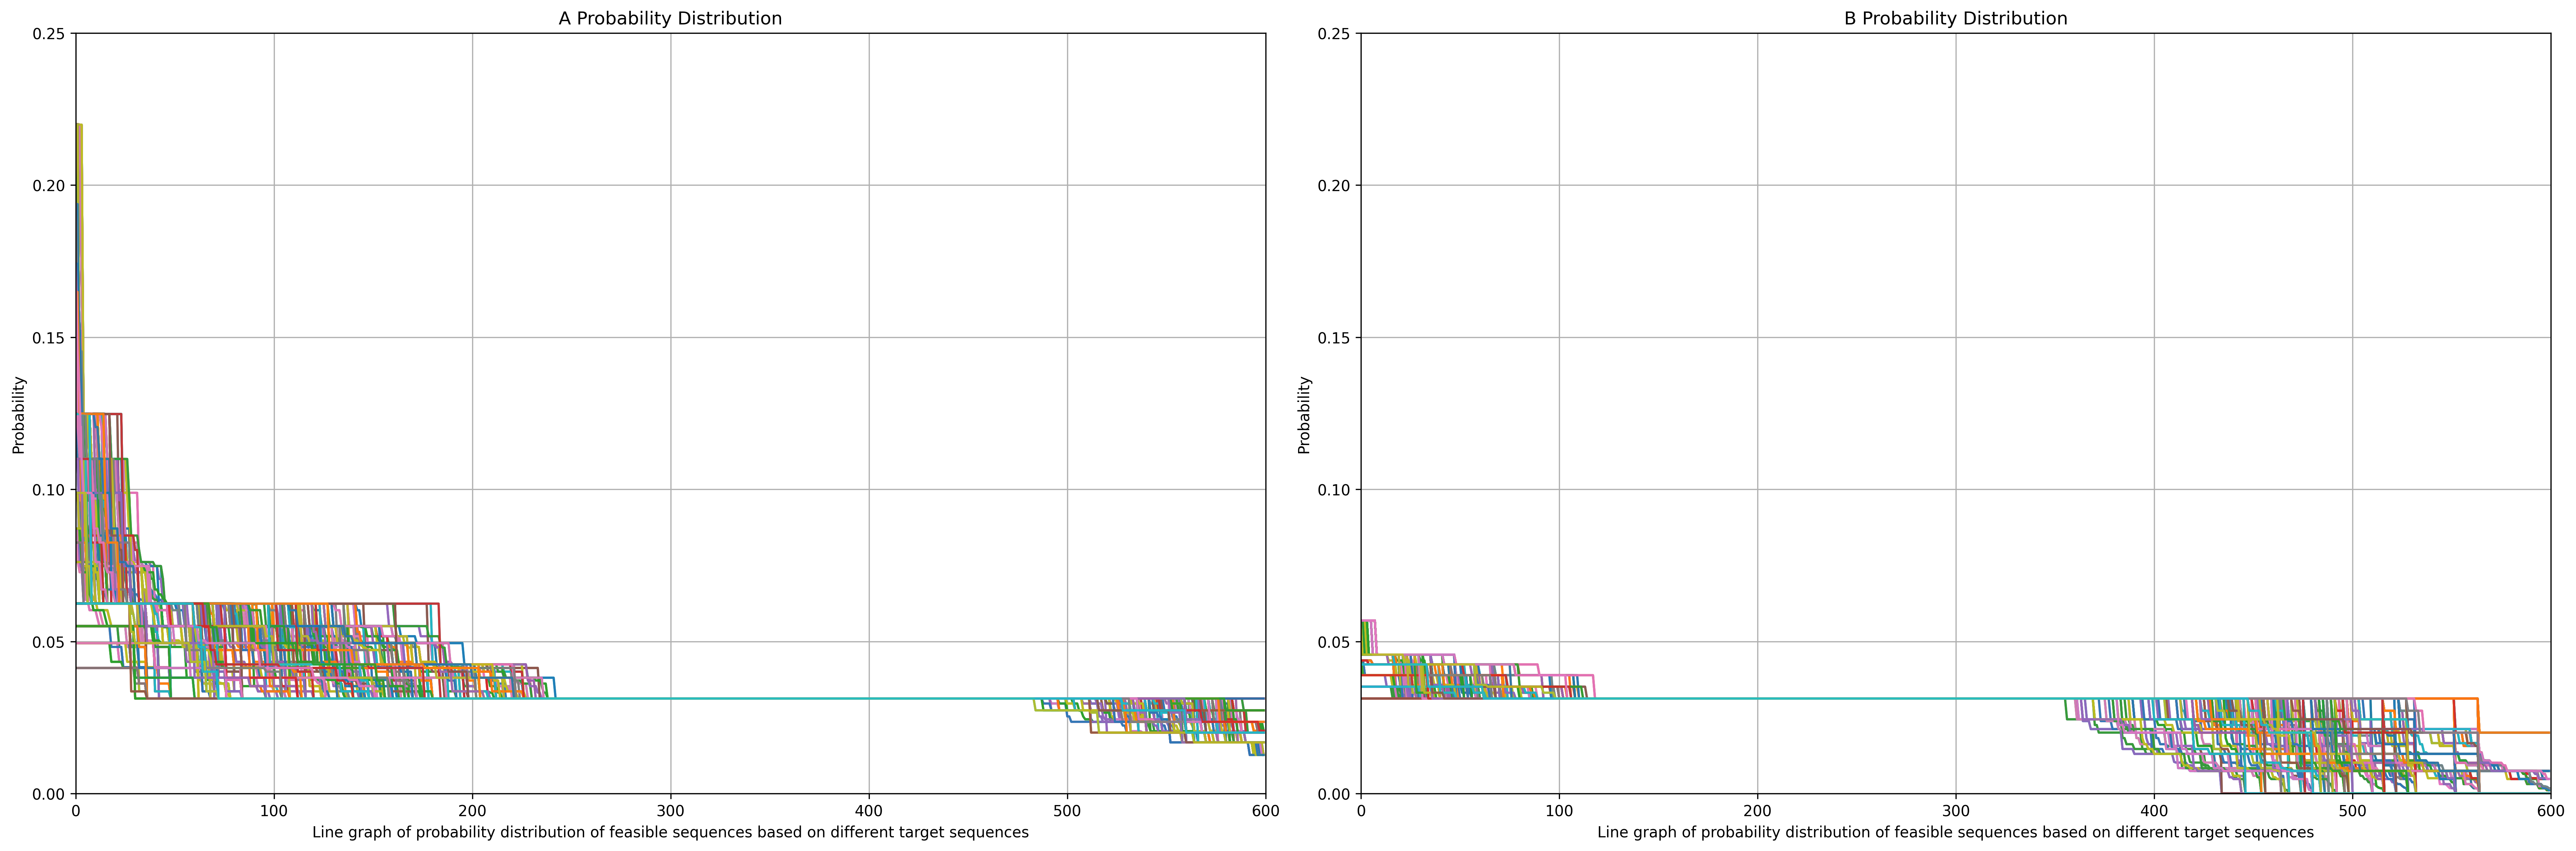

In [65]:
# 基于不同目标序列的可行序列概率分布线图
def plot_prob_distribution(probs, ax, tag):
    prob_values = np.array([[tup[1] for tup in sublist] for sublist in probs])

    for i in range(prob_values.shape[0]):
        ax.plot(prob_values[i], label=f'Line {i+1}', alpha=0.9)
    
    ax.set_xlim(0, 600)
    ax.set_ylim(0, 0.25)
    ax.set_xlabel('Line graph of probability distribution of feasible sequences based on different target sequences')
    ax.set_ylabel('Probability')
    ax.set_title(tag)
    ax.grid()

fig, axs = plt.subplots(1, 2, figsize=(24, 8), dpi=300)

plot_prob_distribution(a_probs, axs[0], 'A Probability Distribution')

plot_prob_distribution(b_probs, axs[1], 'B Probability Distribution')

plt.tight_layout()
plt.savefig('../imgs/prob_distribution.png')
plt.show()

In [72]:
def calculate_std(probs):
    prob_values = np.array([[tup[1] for tup in sublist] for sublist in probs])
    return np.std(prob_values, axis=1)

def calculate_mean(probs):
    prob_values = np.array([[tup[1] for tup in sublist] for sublist in probs])
    return np.mean(prob_values, axis=1)

def calculate_cv(probs):
    mean = calculate_mean(probs)
    std = calculate_std(probs)
    return std / mean

def get_std_cv(probs):
    std = calculate_std(probs)
    cv = calculate_cv(probs)
    return pd.DataFrame({'std': std, 'cv': cv})

In [82]:
a_std_cv, b_std_cv = get_std_cv(a_probs), get_std_cv(b_probs)
print('MINIMUM', np.min(a_std_cv, axis=0), np.min(b_std_cv, axis=0), '\nMAXIMUM', np.max(a_std_cv, axis=0), np.max(b_std_cv, axis=0), sep='\n')

MINIMUM
std    0.00318
cv     0.10206
dtype: float64
std    0.003316
cv     0.106831
dtype: float64

MAXIMUM
std    0.024376
cv     0.556764
dtype: float64
std    0.014536
cv     0.675959
dtype: float64


In [84]:
a_cv, b_cv = a_std_cv['cv'], b_std_cv['cv']
np.min(a_cv), np.argmin(a_cv), np.min(b_cv), np.argmin(b_cv)

(0.10206024241483447, 519, 0.1068307747743323, 327)